Welcome to my notebook

# ======================== IMPORT & CONNECTION ========================

In [1]:
import pandas as pd
from trino import dbapi
from trino.auth import BasicAuthentication
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError # 引入异常处理
from urllib.parse import quote_plus
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import numpy as np


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)


In [2]:
DB_HOST = 'rm-bp1o6283vw74wr4x5.mysql.rds.aliyuncs.com'
DB_PORT = 3306
DB_USER = 'on_ds_test' 
DB_PASS = quote_plus('HC73aA7aeLxJFLFH_@bPeHkv')
DB_NAME = 'on_ds_test'

DATABASE_URL = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}?charset=utf8mb4"

try:
    engine = create_engine(DATABASE_URL)
    print("✅ 数据库连接引擎创建成功。")
except Exception as e:
    print(f"❌ 数据库连接失败: {e}")
    sys.exit()


✅ 数据库连接引擎创建成功。


In [3]:
CURRENT_DATE = pd.to_datetime(datetime.now().date()) # 实际应用中可以使用当前系统日期
CURRENT_DATE_SQL = f"'{CURRENT_DATE.strftime('%Y-%m-%d')}'"
R4M_DATE = CURRENT_DATE - pd.DateOffset(months=4)
R4M_DATE_SQL = f"'{R4M_DATE.strftime('%Y-%m-%d')}'"
R10M_DATE = CURRENT_DATE - pd.DateOffset(months=10)
R10M_DATE_SQL = f"'{R10M_DATE.strftime('%Y-%m-%d')}'"


# ========================== DIGITAL BEHAVIOR ==========================

## ========= READ PRODUCT TABLE ========

In [4]:
# ===================== PRODUCT ===================== #

PRODUCT_MYSQL = 'dim_product_colors_info'
try:
    product = pd.read_sql_table(
        table_name=PRODUCT_MYSQL,
        con=engine
    )

    print(f"\n✅ 成功加载表 '{PRODUCT_MYSQL}'，共 {len(product)} 行。")
    print("\nDataFrame 头部数据:")
    display(product.head()) 

except Exception as e:
    print(f"❌ 加载表时出错: {e}")


✅ 成功加载表 'dim_product_colors_info'，共 7081 行。

DataFrame 头部数据:


,product_id(style),available from,color,gender,shoes_gender,product name,price,model,category,community,style_conditions,terrain,scene_cn,season,picture,style_bottoms,style_tops,vertical,style_sku
0,101.00001,2019-02-14,Navy,mens,mens,Comfort-T Navy M SS19,490.0,Comfort-T,Apparel,Tops and t-shirts,warm,,None,None,https://oss.on-running.cn/contentful_dtc/149f4...,None,Short sleeves,Performance All Day,101CMFRT
1,101.00002,2019-02-14,Grape,mens,mens,Comfort-T Grape M SS19,490.0,Comfort-T,Apparel,Tops and t-shirts,warm,,None,None,https://oss.on-running.cn/contentful_dtc/16b79...,None,Short sleeves,Performance All Day,101CMFRT
2,101.00039,2019-08-13,Camel,mens,mens,Comfort-T Camel M FW19,490.0,Comfort-T,Apparel,Tops and t-shirts,warm,,None,None,https://oss.on-running.cn/contentful_dtc/0281d...,None,Short sleeves,Performance All Day,101CMFRT
3,101.00090,2021-10-04,Olive,mens,mens,On-T Olive M,490.0,On-T,Apparel,Tops and t-shirts,None,,"综训,日常","[""spring"",""summer"",""Autumn"",""Winter""]",https://oss.on-running.cn/contentful_dtc/37bd2...,None,Short sleeves,Performance All Day,101
4,101.00143,2020-02-18,Grey,mens,mens,On-T Grey M SS20,490.0,On-T,Apparel,Tops and t-shirts,None,,"综训,日常","[""spring"",""summer"",""Autumn"",""Winter""]",https://oss.on-running.cn/contentful_dtc/5b016...,None,Short sleeves,Performance All Day,101


## ======== READ TRACKING DATA ========

In [5]:
# 配置Trino连接
conn = dbapi.connect(
    host='192.168.0.163',
    port=8082,
    user='ta',
    # auth=BasicAuthentication("your-username", "your-password"),
    catalog='hive',  # 根据你的Trino配置指定catalog
    schema='ta'
)

# 执行查询
query = f'''SELECT 
"#event_name" as event_name,
"#event_time" as event_time,
"#account_id" as account_id,
"page_type",
"#os" as os,
"login_pt",
"#mp_platform" as mp_platform,
"current_status",
"product_name", --加购 & PDP
"product_type", --加购 & PDP
"search_term", --搜索
"product_id" -- PDP
FROM v_event_3
where "#account_id" is not null 
and "#event_time" > date({R10M_DATE_SQL}) and "#event_time" < date({R4M_DATE_SQL})
and "#event_name" in ('add_to_cart','pdp_view','plp_category_navi_click','search')
'''
event = pd.read_sql(query, conn)


print(event.head())
print(event.shape)
print(event.describe())
print(event.dtypes)


# "to_page_type", --运营位点击
# "item_rank",--运营位点击
# "to_page_path", --运营位点击
# "component_type",--运营位点击
# "module_rank",--运营位点击
# "component_name",--运营位点击
# "item_name",--运营位点击
# "module_name" --运营位点击
# 'MktClick'
# "cat_level", --点击品类
# "cat_list", --点击品类
# "click_type", --点击品类
# "cat_name" --点击品类
# "channel", --广告归因
# "if_employee",
# "page_cat1", 
# "page_cat2",
# "page_cat3",
# "refer_page_type",
# "current_page_path",
# "#province" as province,
# "#city" as city,

/tmp/ipykernel_910/3485514461.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  event = pd.read_sql(query, conn)


    event_name              event_time                            account_id page_type       os login_pt mp_platform current_status         product_name product_type search_term product_id
0  add_to_cart 2025-02-08 04:05:39.247  21ad8ad2-5ddc-4c6e-9216-d02ff9563ba1       pdp      iOS      小程序      wechat             游客         Race Singlet      Apparel        None       None
1  add_to_cart 2025-02-08 04:07:02.292  21ad8ad2-5ddc-4c6e-9216-d02ff9563ba1       pdp      iOS      小程序      wechat             游客              Ultra-T      Apparel        None       None
2  add_to_cart 2025-02-08 05:27:40.482  0f906f4a-af3d-494f-8ee4-86ae1d3215e3       pdp      iOS      小程序      wechat           登录用户              Cloud 6        Shoes        None       None
3  add_to_cart 2025-02-08 03:20:59.756  97881de0-a7ae-46ec-b3d2-f989b1a8d38d       pdp  Android      小程序      wechat           登录用户            Cloud X 4        Shoes        None       None
4  add_to_cart 2025-02-08 04:20:44.659  f9514c3c-e702-4

## ========= PDP & ATC =========

In [6]:
event['event_time'] = pd.to_datetime(event['event_time'])

# 步骤 2: 合并产品类别信息
merged_df = event.merge(
    product[['model', 'vertical']],
    left_on='product_name',
    right_on='model',
    how='left'
)

mapping_dict = {
    'Performance All Day': 'allday',
    'PAD': 'allday',
    'Performance Running': 'running',
    'PR': 'running',
    'Performance Training ': 'training',
    'PTR': 'training',
    'Performance Outdoor': 'outdoor',
    'PO': 'outdoor',
    'Performance Tennis': 'tennis',
    'PT': 'tennis'
}

merged_df['vertical'] = merged_df['vertical'].replace(mapping_dict)

merged_df = merged_df[merged_df['vertical'].isin(['allday','running','training','outdoor','tennis'])]

# 检查是否有未匹配的产品（如果出现NaN，可能需要清洗或补充产品信息表）
if merged_df['vertical'].isnull().any():
    print("⚠️ 警告: 存在未能匹配到产品类别的记录。")
    merged_df.dropna(subset=['vertical'], inplace=True)

print("--- 合并后的数据 (merged_df) ---")
print(merged_df.head())
print("-" * 40)

--- 合并后的数据 (merged_df) ---
    event_name              event_time                            account_id page_type   os login_pt mp_platform current_status  product_name product_type search_term product_id         model vertical
0  add_to_cart 2025-02-08 04:05:39.247  21ad8ad2-5ddc-4c6e-9216-d02ff9563ba1       pdp  iOS      小程序      wechat             游客  Race Singlet      Apparel        None       None  Race Singlet  running
1  add_to_cart 2025-02-08 04:05:39.247  21ad8ad2-5ddc-4c6e-9216-d02ff9563ba1       pdp  iOS      小程序      wechat             游客  Race Singlet      Apparel        None       None  Race Singlet  running
2  add_to_cart 2025-02-08 04:05:39.247  21ad8ad2-5ddc-4c6e-9216-d02ff9563ba1       pdp  iOS      小程序      wechat             游客  Race Singlet      Apparel        None       None  Race Singlet  running
3  add_to_cart 2025-02-08 04:05:39.247  21ad8ad2-5ddc-4c6e-9216-d02ff9563ba1       pdp  iOS      小程序      wechat             游客  Race Singlet      Apparel        None   

In [7]:

# 定义要分别计算的事件名称
EVENT_PDP_VIEW = 'pdp_view'
EVENT_ADD_TO_CART = 'add_to_cart'
BASE_COLUMNS = ['account_id', 'vertical'] # 保持这两个列为计算分组键


# --- 步骤 2: 定义计算函数 (无变化) ---

def calculate_affinity_metrics(df, event_name, prefix):
    """
    计算特定事件的 6 个月次数和距今天数，按 account_id 和 product_category 分组。
    """

    event_df = df[df['event_name'] == event_name].copy()
    if event_df.empty:
        return None

    # A. 计算过去六个月的次数 (6M_Count)
    count_result = event_df.groupby(
        BASE_COLUMNS
    ).size().reset_index(name=f'{prefix}6M_Count')

    # B. 计算最近一次距今的天数 (Days_Since_Last)
    latest_time_result = event_df.groupby(
        BASE_COLUMNS
    )['event_time'].max().reset_index(name='Latest_Action_Time')

    latest_time_result[f'{prefix}Days_Since_Last'] = (
        CURRENT_DATE - latest_time_result['Latest_Action_Time']
    ).dt.days

    # 合并次数和天数结果
    final_metrics = pd.merge(
        count_result,
        latest_time_result.drop(columns=['Latest_Action_Time']),
        on=BASE_COLUMNS,
        how='outer'
    )
    return final_metrics




In [8]:
# --- 步骤 3: 分别计算 PDP Click 和 Add to Cart 并合并中间结果 ---

pdp_result = calculate_affinity_metrics(merged_df, EVENT_PDP_VIEW, 'PDP_View_')
atc_result = calculate_affinity_metrics(merged_df, EVENT_ADD_TO_CART, 'ATC_')



# 将 PDP 和 ATC 的指标结果合并，得到一个包含所有 4 个指标的 DataFrame
# 此时数据结构仍然是 Long Format (多行，一行对应一个 account_id/category)
intermediate_result = pd.merge(
    pdp_result,
    atc_result,
    on=BASE_COLUMNS,
    how='outer'
)

# 填充次数为 0，天数缺失值（如果用户从未有该行为，则留 NaN 或填充 9999）
intermediate_result = intermediate_result.fillna({
    'PDP_View_6M_Count': 0,
    'PDP_View_Days_Since_Last':9999,
    'ATC_6M_Count': 0,
    'ATC_Days_Since_Last':9999
})

intermediate_result.head(10)

,account_id,vertical,PDP_View_6M_Count,PDP_View_Days_Since_Last,ATC_6M_Count,ATC_Days_Since_Last
0,00003ee6-0002-49bc-b0d2-844bece6998e,allday,0.0,9999.0,20.0,127.0
1,00037415-438a-4a85-b67e-d6949e5551e1,allday,10.0,122.0,0.0,9999.0
2,00037415-438a-4a85-b67e-d6949e5551e1,running,2.0,123.0,13.0,148.0
3,0003a126-05d2-4fbd-91ec-760062724ecd,running,0.0,9999.0,16.0,160.0
4,0003d0c6-d747-4861-8fc3-1016e4c30920,allday,0.0,9999.0,156.0,193.0
5,0006ebda-1579-49df-b98a-51487eb7689b,allday,0.0,9999.0,18.0,180.0
6,000dbbac-8b6e-470a-839c-b5a37d0066cb,allday,0.0,9999.0,18.0,225.0
7,000e54c9-bb51-4695-a83d-4c6400a8f6ca,allday,0.0,9999.0,42.0,141.0
8,000e54c9-bb51-4695-a83d-4c6400a8f6ca,outdoor,0.0,9999.0,16.0,165.0
9,000e54c9-bb51-4695-a83d-4c6400a8f6ca,running,0.0,9999.0,310.0,162.0


In [9]:
# --- 步骤 4: 创建完整的基准表 (保障所有组合存在) ---

# !!! 定义必需的 Vertical 列表 !!!
REQUIRED_VERTICALS = ['running', 'training', 'outdoor', 'allday', 'tennis']


all_account_ids = merged_df['account_id'].unique()

# account_id X REQUIRED_VERTICALS Cartesian Product
all_combinations_df = pd.MultiIndex.from_product(
    [all_account_ids, REQUIRED_VERTICALS],
    names=BASE_COLUMNS
).to_frame(index=False)


base_result = pd.merge(
    all_combinations_df,
    intermediate_result,
    on=BASE_COLUMNS,
    how='left'
)

# 再次填充缺失值：所有新增的组合，次数都应该是 0
base_result = base_result.fillna({
    'PDP_View_6M_Count': 0,
    'PDP_View_Days_Since_Last':9999,
    'ATC_6M_Count': 0,
    'ATC_Days_Since_Last':9999
})


# --- 步骤 5: 关键的特征 Wide Format (透视/展开) 转换 ---

# 设置 'account_id' 和 'product_category' 为 MultiIndex
df_pivot = base_result.set_index(BASE_COLUMNS)

# 使用 unstack() 将 'product_category' (vertical) 展开为列名
pdp_atc = df_pivot.unstack(level='vertical')

# 清理列名：扁平化列名 (MetricName_VerticalName)
pdp_atc.columns = [
    f'{col[0]}_{col[1]}' 
    for col in pdp_atc.columns
]

# 重置索引，使 account_id 成为常规列
pdp_atc = pdp_atc.reset_index()

# 检查最终列数，应该为 1 (account_id) + 4 * 5 = 21
expected_cols = 1 + 4 * len(REQUIRED_VERTICALS)
print(f"✅ 最终列数检查: {len(pdp_atc.columns)} (预期: {expected_cols})")
print("\n--- 最终 Wide Format 特征表 (保证包含所有 5 个 Vertical) ---")
pdp_atc.head()

✅ 最终列数检查: 21 (预期: 21)

--- 最终 Wide Format 特征表 (保证包含所有 5 个 Vertical) ---


,account_id,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training
0,00003ee6-0002-49bc-b0d2-844bece6998e,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,20.0,0.0,0.0,0.0,0.0,127.0,9999.0,9999.0,9999.0,9999.0
1,00037415-438a-4a85-b67e-d6949e5551e1,10.0,0.0,2.0,0.0,0.0,122.0,9999.0,123.0,9999.0,9999.0,0.0,0.0,13.0,0.0,0.0,9999.0,9999.0,148.0,9999.0,9999.0
2,0003a126-05d2-4fbd-91ec-760062724ecd,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,16.0,0.0,0.0,9999.0,9999.0,160.0,9999.0,9999.0
3,0003d0c6-d747-4861-8fc3-1016e4c30920,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,156.0,0.0,0.0,0.0,0.0,193.0,9999.0,9999.0,9999.0,9999.0
4,0006ebda-1579-49df-b98a-51487eb7689b,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,18.0,0.0,0.0,0.0,0.0,180.0,9999.0,9999.0,9999.0,9999.0


In [11]:
pdp_atc.describe()

,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training
count,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000,32264.000000
mean,10.560098,1.307215,7.851382,3.222973,0.717146,9301.664022,9772.779042,9213.505176,9713.083282,9859.715782,30.767791,5.468882,27.591619,9.601785,6.176265,4571.337218,8130.030622,5193.320636,7977.199696,8197.778825
std,108.229008,19.185689,71.157935,39.639875,10.640812,2530.062281,1477.559226,2672.300754,1655.972198,1164.603122,329.861087,36.439118,86.015694,49.554079,23.386611,4876.955347,3850.972538,4901.563165,3966.568664,3795.087059
min,0.000000,0.000000,0.000000,0.000000,0.000000,122.000000,122.000000,122.000000,122.000000,122.000000,0.000000,0.000000,0.000000,0.000000,0.000000,122.000000,122.000000,122.000000,122.000000,122.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,177.000000,9999.000000,190.000000,9999.000000,9999.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,4.000000,0.000000,0.000000,0.000000,0.000000,254.000000,9999.000000,9999.000000,9999.000000,9999.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,34.000000,0.000000,26.000000,0.000000,0.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
max,9724.000000,1540.000000,3451.000000,3400.000000,901.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,53229.000000,5643.000000,7279.000000,5564.000000,1885.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000


## ========= NAVI CATEGORY ==========

In [12]:
# 执行查询
query = f'''select "#account_id" as account_id, sum(case when cat_name = '路跑' then 1 else 0 end) as navi_6M_count_running,
sum(case when cat_name = '运动生活' then 1 else 0 end) as navi_6M_count_allday,
sum(case when cat_name = '徒步越野' then 1 else 0 end) as navi_6M_count_outdoor,
sum(case when cat_name = '网球' then 1 else 0 end) as navi_6M_count_tennis,
sum(case when cat_name = '综训' then 1 else 0 end) as navi_6M_count_training
FROM v_event_3 
where "#account_id" is not null 
and "#event_time" > date({R10M_DATE_SQL}) and "#event_time" < date({R4M_DATE_SQL})
and "#event_name" in ('plp_category_navi_click')
and cat_level > 2
group by 1
'''
navi_df = pd.read_sql(query, conn)
navi_df.head(5)

/tmp/ipykernel_910/1557020626.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  navi_df = pd.read_sql(query, conn)


,account_id,navi_6M_count_running,navi_6M_count_allday,navi_6M_count_outdoor,navi_6M_count_tennis,navi_6M_count_training
0,7996ff02-7e31-4fd5-9bc0-79faddfeb208,0,1,0,2,1
1,d5a00f0e-96ae-420a-bf30-8a8828be8707,0,0,0,0,0
2,e127adca-5e91-416d-8053-76cd39ea9c8d,0,0,0,0,0
3,58f708fe-4501-4b98-ab7a-bee358357f47,1,2,2,1,0
4,8126b9a7-2464-4f41-b324-001c1f875da8,31,9,2,0,0


In [13]:
final_digital = pdp_atc.merge(navi_df,on='account_id',how='outer')
final_digital.head(5)

,account_id,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,navi_6M_count_running,navi_6M_count_allday,navi_6M_count_outdoor,navi_6M_count_tennis,navi_6M_count_training
0,00003ee6-0002-49bc-b0d2-844bece6998e,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,20.0,0.0,0.0,0.0,0.0,127.0,9999.0,9999.0,9999.0,9999.0,NaN,NaN,NaN,NaN,NaN
1,00031433-8c5b-4aeb-bbe0-d5946466d931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0
2,00037415-438a-4a85-b67e-d6949e5551e1,10.0,0.0,2.0,0.0,0.0,122.0,9999.0,123.0,9999.0,9999.0,0.0,0.0,13.0,0.0,0.0,9999.0,9999.0,148.0,9999.0,9999.0,0.0,0.0,0.0,8.0,0.0
3,0003a126-05d2-4fbd-91ec-760062724ecd,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,16.0,0.0,0.0,9999.0,9999.0,160.0,9999.0,9999.0,NaN,NaN,NaN,NaN,NaN
4,0003d0c6-d747-4861-8fc3-1016e4c30920,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,156.0,0.0,0.0,0.0,0.0,193.0,9999.0,9999.0,9999.0,9999.0,NaN,NaN,NaN,NaN,NaN


# ========================= COMMUNITY ACTIVITY =======================

## ========= READ ACTIVITY DATA ========

In [14]:
query = f'''SELECT t1.*,t2.name,t2.activity_label
  FROM `dwd_community_activity` t1
  join `dim_community_info` t2
  on t1.community_activity_id  =  t2.id
  '''

  # where CAST(t1.created_at AS DATE) < {R4M_DATE_SQL}
try:
    activity = pd.read_sql(query, engine)
    print("\n--- 数据库数据加载到 Pandas DataFrame ---")
    print(activity.head())
except Exception as e:
    print(f"读取数据失败: {e}")



--- 数据库数据加载到 Pandas DataFrame ---
   id  community_activity_id                            member_uid member_name shoes_size          created_at         check_in_at created_date check_in_date                name activity_label
0   3                     10  a0c5737c-b9f1-4f27-9123-35e7d8635b35        None         37 2025-07-31 04:29:24 2025-08-02 08:42:13   2025-07-31    2025-08-02        运动康复&损伤预防分享会           昂跑夏训
1   7                     12  ecccb892-9768-43f2-808a-697a92819c37        None         41 2025-07-31 08:03:12 2025-08-03 06:01:37   2025-07-31    2025-08-03  「开启昂跑夏训」8.3佛慧山跑坡训练           昂跑夏训
2   8                     12  8d042a53-a52b-4d0e-a739-26ddf86f0407        None         39 2025-07-31 08:06:08 2025-08-03 06:03:13   2025-07-31    2025-08-03  「开启昂跑夏训」8.3佛慧山跑坡训练           昂跑夏训
3   9                     12  9ce56446-8045-4410-8350-c85b736b8c63        None         42 2025-07-31 08:08:16                 NaT   2025-07-31          None  「开启昂跑夏训」8.3佛慧山跑坡训练           昂跑夏训
4  10

## ========= ACTIVITY PARTICIPATION ========

In [15]:

cond_run = activity['name'].str.contains(
    '跑|lsd|间歇|变速跑|例跑|夜跑|公里|km|shake out run|run now|畅跑|跑坡', 
    na=False, case=False
)

cond_outdoor = activity['name'].str.contains(
    '徒步|山|龙洞', 
    na=False, case=False
)

cond_train = activity['name'].str.contains(
    '训练|力量|康复|crossfit|training|hyrox|备赛|分享会|夏训|课程', 
    na=False, case=False
)

cond_tennis = activity['name'].str.contains(
    '网球', 
    na=False, case=False
)

conditions = [cond_run, cond_outdoor, cond_train, cond_tennis]
choices = ['running', 'outdoor', 'train','tennis']
default_value = 'allday' 

activity['activity_category'] = np.select(conditions, choices, default=default_value)



result = activity.dropna(subset=['activity_category']).groupby(
    ['member_uid', 'activity_category']
).size().reset_index(name='count')

print(result.head())

                             member_uid activity_category  count
0  00005bc7-d65f-48f4-8ce1-611fefb5ea36            allday      1
1  0011bb78-2a44-4e59-ad5b-d8d69498bd83           running      1
2  003f2002-3614-4ec3-9f44-29d73bc79d7a           running      1
3  0051d368-d613-434f-9782-378660355910           running      3
4  0051e08a-ec47-41cc-bd59-dc66ae16b06d            allday      1


In [16]:
# --- 步骤 5: 关键的特征 Wide Format (透视/展开) 转换 ---


# !!! 定义必需的 Vertical 列表 !!!
REQUIRED_VERTICALS = ['running', 'training', 'outdoor', 'allday', 'tennis']
BASE_COLUMNS = ['member_uid','activity_category']

all_account_ids = result['member_uid'].unique()



# account_id X REQUIRED_VERTICALS Cartesian Product
all_combinations_df = pd.MultiIndex.from_product(
    [all_account_ids, REQUIRED_VERTICALS],
    names=BASE_COLUMNS
).to_frame(index=False)



base_result = pd.merge(
    all_combinations_df,
    result,
    on=BASE_COLUMNS,
    how='left'
)

# --- 步骤 5: 关键的特征 Wide Format (透视/展开) 转换 ---

# 设置 'account_id' 和 'product_category' 为 MultiIndex
df_pivot = base_result.set_index(BASE_COLUMNS)

# 使用 unstack() 将 'product_category' (vertical) 展开为列名
final_activity = df_pivot.unstack(level='activity_category')

# 清理列名：扁平化列名 (MetricName_VerticalName)
final_activity.columns = [
    f'activity_{col[0]}_{col[1]}' 
    for col in final_activity.columns
]

# 重置索引，使 account_id 成为常规列
final_activity = final_activity.fillna(0).reset_index()

# 检查最终列数，应该为 6
expected_cols = 1 + len(REQUIRED_VERTICALS)
print(f"✅ 最终列数检查: {len(final_activity.columns)} (预期: {expected_cols})")
print("\n--- 最终 Wide Format 特征表 (保证包含所有 5 个 Vertical) ---")
print(final_activity.head())


✅ 最终列数检查: 6 (预期: 6)

--- 最终 Wide Format 特征表 (保证包含所有 5 个 Vertical) ---
                             member_uid  activity_count_allday  activity_count_outdoor  activity_count_running  activity_count_tennis  activity_count_training
0  00005bc7-d65f-48f4-8ce1-611fefb5ea36                    1.0                     0.0                     0.0                    0.0                      0.0
1  0011bb78-2a44-4e59-ad5b-d8d69498bd83                    0.0                     0.0                     1.0                    0.0                      0.0
2  003f2002-3614-4ec3-9f44-29d73bc79d7a                    0.0                     0.0                     1.0                    0.0                      0.0
3  0051d368-d613-434f-9782-378660355910                    0.0                     0.0                     3.0                    0.0                      0.0
4  0051e08a-ec47-41cc-bd59-dc66ae16b06d                    1.0                     0.0                     0.0                    0.0  

# ========================= RFM BY VERTICAL =======================

In [17]:
query = f'''-- 1. 定义计算基准日期 (TODAY) 和时间窗口
WITH
  params AS (
    SELECT
      CAST({R4M_DATE_SQL} AS DATE) AS TODAY,
      DATE_SUB(CAST({R4M_DATE_SQL} AS DATE), INTERVAL 4 MONTH) AS DATE_4M_AGO,
      DATE_SUB(CAST({R4M_DATE_SQL} AS DATE), INTERVAL 1 YEAR) AS DATE_1Y_AGO
  ),
  
-- 2. 筛选相关品类并标准化数据
filtered_orders AS (
  SELECT
    member_uid,
    CAST(date AS DATE) AS purchase_date, -- 确保时间是DATE类型
    case when vertical = 'Performance All Day' or vertical = 'PAD' then 'all_day'
      when vertical = 'Performance Running' or vertical = 'PR' then 'running'
  when vertical = 'Performance Training ' or vertical = 'PTR' then 'training'
  when vertical = 'Performance Tennis' or vertical = 'PT' then 'tennis'
  when vertical = 'Performance Outdoor' or vertical = 'PO' then 'outdoor' end as vertical,
    `AR Revenue` as purchase_amount
  FROM
    `dwd_dtc_store_sales_order_detail` t1
  LEFT JOIN `dim_product_colors_info` t2
  ON t1.`product_id(style)` = t2.`product_id(style)` 
  where (member_uid != '' or member_uid != NULL ) and is_gift = 0 
),

-- 3. 计算 R (Recency) - 距今最近一次购买的天数
R_features AS (
  SELECT
    t1.member_uid,
    t1.vertical,
    DATEDIFF(p.TODAY,MAX(t1.purchase_date)) AS recency_days 
  FROM
    filtered_orders AS t1
  CROSS JOIN 
    params AS p
  GROUP BY
    t1.member_uid, t1.vertical, p.TODAY
),

-- 4. 计算 F & M (6个月)
FM_4M_features AS (
  SELECT
    t1.member_uid,
    t1.vertical,
    COUNT(*) AS frequency_4m,
    SUM(t1.purchase_amount) AS monetary_4m
  FROM
    filtered_orders AS t1, params AS p
  WHERE
    t1.purchase_date >= p.DATE_4M_AGO
  GROUP BY
    1, 2
),

-- 5. 计算 F & M (2年)
FM_1Y_features AS (
  SELECT
    t1.member_uid,
    t1.vertical,
    COUNT(*) AS frequency_1y,
    SUM(t1.purchase_amount) AS monetary_1y
  FROM
    filtered_orders AS t1, params AS p
  WHERE
    t1.purchase_date >= p.DATE_1Y_AGO
  GROUP BY
    1, 2
)

-- 6. 最终的 Full Join 和 Pivot (使用条件聚合实现)
SELECT
  t1.member_uid,

  -- R 特征
  MAX(CASE WHEN t2.vertical = 'running' THEN t2.recency_days ELSE NULL END) AS R_running,
  MAX(CASE WHEN t2.vertical = 'tennis' THEN t2.recency_days ELSE NULL END) AS R_tennis,
  MAX(CASE WHEN t2.vertical = 'all_day' THEN t2.recency_days ELSE NULL END) AS R_allday,
  MAX(CASE WHEN t2.vertical = 'training' THEN t2.recency_days ELSE NULL END) AS R_training,
  MAX(CASE WHEN t2.vertical = 'outdoor' THEN t2.recency_days ELSE NULL END) AS R_outdoor,

  -- F_4M 特征
  COALESCE(MAX(CASE WHEN t3.vertical = 'running' THEN t3.frequency_4m ELSE NULL END), 0) AS F_4m_running,
  COALESCE(MAX(CASE WHEN t3.vertical = 'tennis' THEN t3.frequency_4m ELSE NULL END), 0) AS F_4m_tennis,
  COALESCE(MAX(CASE WHEN t3.vertical = 'all_day' THEN t3.frequency_4m ELSE NULL END), 0) AS F_4m_allday,
  COALESCE(MAX(CASE WHEN t3.vertical = 'training' THEN t3.frequency_4m ELSE NULL END), 0) AS F_4m_training,
  COALESCE(MAX(CASE WHEN t3.vertical = 'outdoor' THEN t3.frequency_4m ELSE NULL END), 0) AS F_4m_outdoor,

  -- M_4M 特征
  COALESCE(MAX(CASE WHEN t3.vertical = 'running' THEN t3.monetary_4m ELSE NULL END), 0) AS M_4m_running,
  COALESCE(MAX(CASE WHEN t3.vertical = 'tennis' THEN t3.monetary_4m ELSE NULL END), 0) AS M_4m_tennis,
  COALESCE(MAX(CASE WHEN t3.vertical = 'all_day' THEN t3.monetary_4m ELSE NULL END), 0) AS M_4m_allday,
  COALESCE(MAX(CASE WHEN t3.vertical = 'training' THEN t3.monetary_4m ELSE NULL END), 0) AS M_4m_training,
  COALESCE(MAX(CASE WHEN t3.vertical = 'outdoor' THEN t3.monetary_4m ELSE NULL END), 0) AS M_4m_outdoor,

  -- F_1Y 特征
  COALESCE(MAX(CASE WHEN t4.vertical = 'running' THEN t4.frequency_1y ELSE NULL END), 0) AS F_1y_running,
  COALESCE(MAX(CASE WHEN t4.vertical = 'tennis' THEN t4.frequency_1y ELSE NULL END), 0) AS F_1y_tennis,
  COALESCE(MAX(CASE WHEN t4.vertical = 'all_day' THEN t4.frequency_1y ELSE NULL END), 0) AS F_1y_allday,
  COALESCE(MAX(CASE WHEN t4.vertical = 'training' THEN t4.frequency_1y ELSE NULL END), 0) AS F_1y_training,
  COALESCE(MAX(CASE WHEN t4.vertical = 'outdoor' THEN t4.frequency_1y ELSE NULL END), 0) AS F_1y_outdoor,

  -- M_1Y 特征
  COALESCE(MAX(CASE WHEN t4.vertical = 'running' THEN t4.monetary_1y ELSE NULL END), 0) AS M_1y_running,
  COALESCE(MAX(CASE WHEN t4.vertical = 'tennis' THEN t4.monetary_1y ELSE NULL END), 0) AS M_1y_tennis,
  COALESCE(MAX(CASE WHEN t4.vertical = 'all_day' THEN t4.monetary_1y ELSE NULL END), 0) AS M_1y_allday,
  COALESCE(MAX(CASE WHEN t4.vertical = 'training' THEN t4.monetary_1y ELSE NULL END), 0) AS M_1y_training,
  COALESCE(MAX(CASE WHEN t4.vertical = 'outdoor' THEN t4.monetary_1y ELSE NULL END), 0) AS M_1y_outdoor

FROM
  -- 获取所有用户 ID
  (SELECT DISTINCT member_uid FROM `dwd_dtc_store_sales_order_detail` 
  where (member_uid != '' or member_uid != NULL )) AS t1

  -- 左连接 R 特征
  LEFT JOIN R_features AS t2 ON t1.member_uid = t2.member_uid
  -- 左连接 FM 6M 特征
  LEFT JOIN FM_4M_features AS t3 ON t1.member_uid = t3.member_uid AND t2.vertical = t3.vertical
  -- 左连接 FM 2Y 特征
  LEFT JOIN FM_1Y_features AS t4 ON t1.member_uid = t4.member_uid AND t2.vertical = t4.vertical

GROUP BY
  t1.member_uid
ORDER BY
  t1.member_uid
  '''

try:
    base_RFM_vertical = pd.read_sql(query, engine)
    print("\n--- 数据库数据加载到 Pandas DataFrame ---")
    print(base_RFM_vertical.head())
except Exception as e:
    print(f"读取数据失败: {e}")





--- 数据库数据加载到 Pandas DataFrame ---
                             member_uid  R_running  R_tennis  R_allday  R_training  R_outdoor  F_4m_running  F_4m_tennis  F_4m_allday  F_4m_training  F_4m_outdoor  M_4m_running  M_4m_tennis  M_4m_allday  M_4m_training  M_4m_outdoor  F_1y_running  F_1y_tennis  F_1y_allday  F_1y_training  F_1y_outdoor  M_1y_running  M_1y_tennis  M_1y_allday  M_1y_training  M_1y_outdoor
0  00002e60-ebe4-44fd-a7d2-4cbe3b258915      702.0       NaN       NaN         NaN        NaN             0            0            0              0             0           0.0          0.0          0.0            0.0           0.0             0            0            0              0             0           0.0          0.0          0.0            0.0           0.0
1  0000b440-edb7-4caa-9d38-e2ecd7f51fc1      394.0       NaN       NaN         NaN        NaN             0            0            0              0             0           0.0          0.0          0.0            0.0        

In [18]:
# 负数变成0
cols_to_clip = base_RFM_vertical.columns.drop('member_uid')

# 2. 对这些数值列应用 clip(lower=0)
# df[cols_to_clip] = ... 只对选定的列进行赋值操作
base_RFM_vertical[cols_to_clip] = base_RFM_vertical[cols_to_clip].clip(lower=0)

base_RFM_vertical.describe()

,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor
count,361646.000000,73478.000000,381765.000000,135245.000000,111664.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000,802192.000000
mean,214.373490,172.161069,172.763999,110.444216,215.730576,0.485805,0.097444,0.558809,0.195901,0.116056,296.864647,58.057199,296.413916,102.620788,75.291377,0.739701,0.151091,0.857391,0.284247,0.196694,501.664250,98.083654,505.250970,169.169932,139.369156
std,237.558708,205.357833,213.463841,120.386477,232.643228,1.487112,0.710651,1.884479,0.734532,0.591007,864.886232,386.021528,1061.914254,397.424764,436.262505,1.908976,0.912386,2.307788,0.869817,0.778830,1199.102471,538.513334,1435.162533,513.340003,589.940615
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,119.000000,97.000000,91.000000,73.000000,146.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,366.000000,299.000000,281.000000,172.000000,337.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,690.000000,0.000000,1090.000000,0.000000,0.000000
max,1270.000000,1151.000000,1270.000000,420.000000,1270.000000,335.000000,244.000000,934.000000,57.000000,89.000000,90662.700000,66010.000000,388090.000000,51170.000000,99974.700000,425.000000,286.000000,1034.000000,65.000000,133.000000,120803.250000,101158.000000,388090.000000,51170.000000,115319.900000


In [19]:
final_RFM_vertical = base_RFM_vertical.fillna({
    'R_running': 9999,
    'R_tennis': 9999,
    'R_allday': 9999,
    'R_training':9999,
    'R_outdoor':9999
})

In [20]:
final_RFM_vertical.shape

(802192, 26)

# ========================= MERGE & PROCESS ===========================

## ============= READ MEMBER & EMPLOYEE TABLE & MERGE =============

In [21]:
# ===================== EMPLOYEE ===================== #

EMPLOYEE_MYSQL = 'stg_employee'
try:
    employee = pd.read_sql_table(
        table_name=EMPLOYEE_MYSQL, 
        con=engine
    )

    print(f"\n✅ 成功加载表 '{EMPLOYEE_MYSQL}'，共 {len(employee)} 行。")
    print("\nDataFrame 头部数据:")
    # display(employee.head()) 

except Exception as e:
    print(f"❌ 加载表时出错: {e}")
    

# ===================== MEMBER ===================== #

MEMBER_MYSQL = 'dwd_crm_members'
try:
    member = pd.read_sql_table(
        table_name=MEMBER_MYSQL, 
        con=engine
    )

    print(f"\n✅ 成功加载表 '{MEMBER_MYSQL}'，共 {len(member)} 行。")
    print("\nDataFrame 头部数据:")
    # display(member.head()) 

except Exception as e:
    print(f"❌ 加载表时出错: {e}")
    

# ===================== FILTER EMPLOYEE ===================== #  
employee_ids = employee['member_uid'].unique()
member_filtered = member[~member['member_uid'].isin(employee_ids)].copy()

print(f"\n✅ 成功过滤员工，共 {len(member_filtered)} 行。")
# display(member_filtered.head()) 



✅ 成功加载表 'stg_employee'，共 1058 行。

DataFrame 头部数据:

✅ 成功加载表 'dwd_crm_members'，共 1084254 行。

DataFrame 头部数据:

✅ 成功过滤员工，共 1083436 行。


In [55]:
all_member_df = member_filtered[['member_uid']].merge(final_digital, left_on='member_uid',right_on='account_id', how='left') \
              .merge(final_activity, on='member_uid', how='left') \
              .merge(final_RFM_vertical, on='member_uid', how='left')

# 查看结果
all_member_df.head()

,member_uid,account_id,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,navi_6M_count_running,navi_6M_count_allday,navi_6M_count_outdoor,navi_6M_count_tennis,navi_6M_count_training,activity_count_allday,activity_count_outdoor,activity_count_running,activity_count_tennis,activity_count_training,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor
0,4af0541c-148f-4f5c-a9f3-7e434b7f09f2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9cf1e32c-e4b3-49c1-bd38-fbaf93552a33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14749aac-e36a-4477-bfa1-fede3b3c3fe4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,568.0,9999.0,568.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,793d6c2d-2230-4e64-8287-176a78e0a8bd,793d6c2d-2230-4e64-8287-176a78e0a8bd,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,72.0,104.0,415.0,32.0,28.0,135.0,149.0,127.0,194.0,207.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,9999.0,0.0,116.0,80.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0
4,e69b772c-34c0-49de-80c9-92f4dc256a7c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ============== TOUCHPOINTS ANALYSIS ===============

In [56]:
final_df = all_member_df.copy()
final_df['valid_column_count'] = final_df.count(axis=1)
print(final_df.groupby('valid_column_count').size().reset_index(name='row_count'))


    valid_column_count  row_count
0                    1     637025
1                    6       2700
2                    7       3827
3                   12         78
4                   22      10712
5                   26     402209
6                   27       3341
7                   31        287
8                   32       5538
9                   37         50
10                  47       9583
11                  52       7958
12                  57        128


In [45]:
temp = final_df[final_df['valid_column_count']>1].merge(member_filtered[['member_uid','member_channel','member_uid_one','register_channel','is_omni_channel_member']],on='member_uid',how='left')


In [47]:
temp.groupby(['member_channel','is_omni_channel_member']).size().reset_index(name='row_count')

,member_channel,is_omni_channel_member,row_count
0,DTC-Douyin,false,30096
1,DTC-Douyin,true,2785
2,DTC-Mp & Web,true,83999
3,DTC-RETAIL,true,236813
4,DTC-Tmall,false,74380
5,DTC-Tmall,true,18338


## ================ DROP MEMBERS W/O TOUCHPOINTS ================

In [57]:

final_df = final_df[
    final_df['valid_column_count'] != 1
]

# 2. 删除列：删除 'account_id' 这一列
# axis=1 表示删除的是列；inplace=True 表示直接修改原 DataFrame
final_df.drop(columns=['account_id','valid_column_count'], inplace=True)
display(final_df.head(5))
print(final_df.shape)

,member_uid,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,navi_6M_count_running,navi_6M_count_allday,navi_6M_count_outdoor,navi_6M_count_tennis,navi_6M_count_training,activity_count_allday,activity_count_outdoor,activity_count_running,activity_count_tennis,activity_count_training,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor
2,14749aac-e36a-4477-bfa1-fede3b3c3fe4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,568.0,9999.0,568.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,793d6c2d-2230-4e64-8287-176a78e0a8bd,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,72.0,104.0,415.0,32.0,28.0,135.0,149.0,127.0,194.0,207.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,9999.0,0.0,116.0,80.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0
5,142a2891-6887-4066-8844-4afcc2d551df,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,9999.0,0.0,9999.0,9999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0
7,ce47f1ba-04b9-4733-a43e-ede1fb9a007d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,699.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,55dca87a-48fb-4844-a891-a9d1b38c265e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,9999.0,9999.0,9999.0,635.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(446411, 56)


final_df| # | valid\_column\_count | row\_count | 描述 (Description) |
| :---: | :------------------: | :---------: | :------------------ |
| 0 | 1 | 610098 | no vertical touchpoints |
| 1 | 5 | 1854 | only activity |
| 2 | 22 | 43025 | only digital |
| 3 | 26 | 379896 | only RFM |
| 4 | 30 | 115 | activity + RFM |
| 5 | 47 | 43237 | digital + RFM |
| 6 | 51 | 381 | activity + digital + RFM |

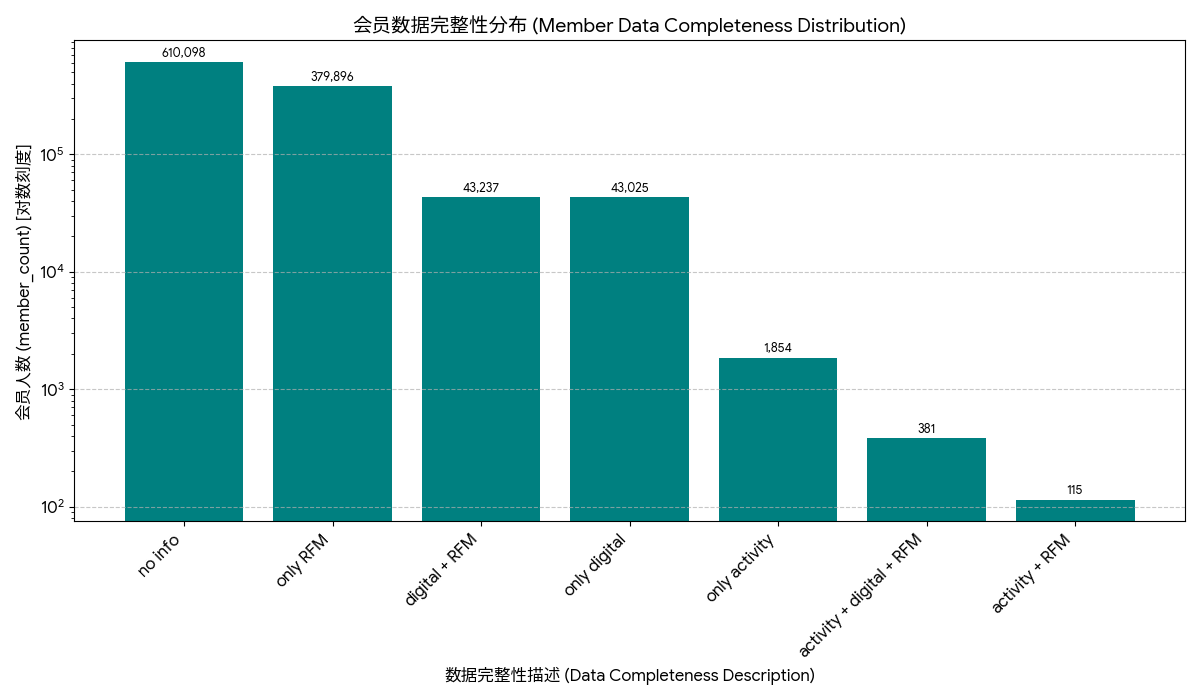

In [89]:
final_df.head()

,member_uid,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,navi_6M_count_running,navi_6M_count_allday,navi_6M_count_outdoor,navi_6M_count_tennis,navi_6M_count_training,activity_count_allday,activity_count_outdoor,activity_count_running,activity_count_tennis,activity_count_training,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor
2,14749aac-e36a-4477-bfa1-fede3b3c3fe4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,563.0,9999.0,563.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,793d6c2d-2230-4e64-8287-176a78e0a8bd,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,72.0,104.0,415.0,32.0,28.0,131.0,145.0,123.0,190.0,203.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,9999.0,0.0,111.0,75.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0
5,142a2891-6887-4066-8844-4afcc2d551df,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,9999.0,0.0,9999.0,9999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0
7,ce47f1ba-04b9-4733-a43e-ede1fb9a007d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,694.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,55dca87a-48fb-4844-a891-a9d1b38c265e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9999.0,9999.0,9999.0,9999.0,630.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ================ NORMALIZATION ==================

In [58]:
final_df_imputed = final_df.copy()

# ============= Missing value impute =============
all_features = [col for col in final_df_imputed.columns if any(keyword in col for keyword in ['R_', 'F_', 'M_', 'PDP_', 'ATC_', 'activity_'])]

for col in all_features:
    if col.startswith('R_') or col.startswith('PDP_View_Days_Since_') or col.startswith('ATC_Days_Since_'):
        # 填充 Recency (R) 为9999
        final_df_imputed[col].fillna(9999, inplace=True)
    else:
        # 填充 F, M, Ratio, PDP, ATC, Activity 等为 0 (假设缺失即为0次/0金额)
        final_df_imputed[col].fillna(0, inplace=True)
        
final_df_imputed.head(5)

/tmp/ipykernel_910/474617980.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df_imputed[col].fillna(0, inplace=True)
/tmp/ipykernel_910/474617980.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,member_uid,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,navi_6M_count_running,navi_6M_count_allday,navi_6M_count_outdoor,navi_6M_count_tennis,navi_6M_count_training,activity_count_allday,activity_count_outdoor,activity_count_running,activity_count_tennis,activity_count_training,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor
2,14749aac-e36a-4477-bfa1-fede3b3c3fe4,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,568.0,9999.0,568.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,793d6c2d-2230-4e64-8287-176a78e0a8bd,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,72.0,104.0,415.0,32.0,28.0,135.0,149.0,127.0,194.0,207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,116.0,80.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0
5,142a2891-6887-4066-8844-4afcc2d551df,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,0.0,9999.0,9999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1290.0,0.0,0.0
7,ce47f1ba-04b9-4733-a43e-ede1fb9a007d,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,699.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,55dca87a-48fb-4844-a891-a9d1b38c265e,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,635.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# # 初始化所需的缩放器
# min_max_scaler = MinMaxScaler()
# robust_scaler = RobustScaler()

# df_normalized = final_df_imputed.copy()

# # --- 1. 处理 Recency (R) 类特征：使用 RobustScaler ---

# recency_cols = [col for col in all_features if col.startswith('R_') or col.startswith('PDP_View_Days_Since_') or col.startswith('ATC_Days_Since_')]

# for col in recency_cols:
#     # 1.1 使用 RobustScaler 进行缩放（对极值鲁棒）
#     # RobustScaler 结果范围不固定，但能减轻极值影响
#     df_normalized[col + '_robust'] = robust_scaler.fit_transform(final_df_imputed[[col]])
    
#     # 1.2 对 RobustScaler 的结果进行 MinMax 缩放，强制到 0-1 范围
#     # 确保得分在 0-1 之间，同时保留 RobustScaler 对极值的鲁棒性
#     df_normalized[col + '_norm'] = min_max_scaler.fit_transform(df_normalized[[col + '_robust']])
    
#     # 1.3 反转得分 (值越小，得分越接近 1)
#     df_normalized[col + '_score'] = 1 - df_normalized[col + '_norm']
    
#     df_normalized.drop(columns=[col + '_norm'], inplace=True)
#     df_normalized.drop(columns=[col + '_robust'], inplace=True)


# # --- 2. 处理 Positive (F/M/Count) 类特征：使用 Log + MinMax ---

# positive_cols = [col for col in all_features if col not in recency_cols]

# for col in positive_cols:
#     # 2.1 对特征进行对数变换 (np.log1p = log(1+x))，压缩大值
#     # 确保特征值非负，并假设 0 填充是正确的
#     df_normalized[col + '_log'] = np.log1p(final_df_imputed[[col]])
    
#     # 2.2 使用 MinMaxScaler 进行标准化 (值越大，得分越接近 1)
#     df_normalized[col + '_score'] = min_max_scaler.fit_transform(df_normalized[[col + '_log']])

#     # 清理中间列 (可选)
#     df_normalized.drop(columns=[col + '_log'], inplace=True)
    
    
# print("--- 特征标准化完成 ---")
# df_normalized.head(5)


df_processed_rank = final_df_imputed.copy()

# 2. 百分位数标准化 (核心改变)

# 2.1 处理 Recency (R) 类特征
recency_cols = [col for col in all_features if col.startswith('R_') or col.startswith('PDP_View_Days_Since_') or col.startswith('ATC_Days_Since_')]

for col in recency_cols:
    # 计算百分位数排名 (值越小，排名越靠前，所以排名百分位越低)
    # 反转得分：值越小，排名越低，但我们希望得分越高，所以用 1 - rank_percentile
    df_processed_rank[f'{col}_score'] = 1 - df_processed_rank[col].rank(pct=True, method='average')
    df_processed_rank[f'{col}_score'].fillna(0, inplace=True) # 填充可能产生的NaN

# 2.2 处理 Positive (F/M/Count) 类特征
positive_cols = [col for col in all_features if col not in recency_cols]

for col in positive_cols:
    # 计算百分位数排名 (值越大，排名越高，百分位数越高)
    df_processed_rank[f'{col}_score'] = df_processed_rank[col].rank(pct=True, method='average')
    df_processed_rank[f'{col}_score'].fillna(0, inplace=True) # 填充可能产生的NaN
    
print("--- 特征标准化完成 ---")
df_processed_rank.head(5)

/tmp/ipykernel_910/3970396784.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed_rank[f'{col}_score'].fillna(0, inplace=True) # 填充可能产生的NaN
/tmp/ipykernel_910/3970396784.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

--- 特征标准化完成 ---


/tmp/ipykernel_910/3970396784.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed_rank[f'{col}_score'].fillna(0, inplace=True) # 填充可能产生的NaN
/tmp/ipykernel_910/3970396784.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

,member_uid,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,navi_6M_count_running,navi_6M_count_allday,navi_6M_count_outdoor,navi_6M_count_tennis,navi_6M_count_training,activity_count_allday,activity_count_outdoor,activity_count_running,activity_count_tennis,activity_count_training,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor,PDP_View_Days_Since_Last_allday_score,PDP_View_Days_Since_Last_outdoor_score,PDP_View_Days_Since_Last_running_score,PDP_View_Days_Since_Last_tennis_score,PDP_View_Days_Since_Last_training_score,ATC_Days_Since_Last_allday_score,ATC_Days_Since_Last_outdoor_score,ATC_Days_Since_Last_running_score,ATC_Days_Since_Last_tennis_score,ATC_Days_Since_Last_training_score,R_running_score,R_tennis_score,R_allday_score,R_training_score,R_outdoor_score,PDP_View_6M_Count_allday_score,PDP_View_6M_Count_outdoor_score,PDP_View_6M_Count_running_score,PDP_View_6M_Count_tennis_score,PDP_View_6M_Count_training_score,ATC_6M_Count_allday_score,ATC_6M_Count_outdoor_score,ATC_6M_Count_running_score,ATC_6M_Count_tennis_score,ATC_6M_Count_training_score,navi_6M_count_running_score,navi_6M_count_allday_score,navi_6M_count_outdoor_score,navi_6M_count_tennis_score,navi_6M_count_training_score,activity_count_allday_score,activity_count_outdoor_score,activity_count_running_score,activity_count_tennis_score,activity_count_training_score,F_4m_running_score,F_4m_tennis_score,F_4m_allday_score,F_4m_training_score,F_4m_outdoor_score,M_4m_running_score,M_4m_tennis_score,M_4m_allday_score,M_4m_training_score,M_4m_outdoor_score,F_1y_running_score,F_1y_tennis_score,F_1y_allday_score,F_1y_training_score,F_1y_outdoor_score,M_1y_running_score,M_1y_tennis_score,M_1y_allday_score,M_1y_training_score,M_1y_outdoor_score
2,14749aac-e36a-4477-bfa1-fede3b3c3fe4,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,568.0,9999.0,568.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.497608,0.499255,0.497277,0.499033,0.499573,0.480501,0.493429,0.482783,0.492910,0.493726,0.559290,0.458594,0.582065,0.421139,0.427355,0.49761,0.499257,0.497279,0.499036,0.499576,0.480503,0.493431,0.482785,0.492912,0.493728,0.492921,0.492747,0.496731,0.496874,0.497063,0.499409,0.499928,0.496743,0.500001,0.500001,0.374168,0.477629,0.372352,0.448789,0.465541,0.389822,0.481697,0.389235,0.45709,0.471054,0.314493,0.465598,0.314923,0.424436,0.442793,0.333336,0.470852,0.334562,0.434652,0.450479
3,793d6c2d-2230-4e64-8287-176a78e0a8bd,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,72.0,104.0,415.0,32.0,28.0,135.0,149.0,127.0,194.0,207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,116.0,80.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0,0.497608,0.499255,0.497277,0.499033,0.499573,0.995548,0.997428,0.997979,0.992765,0.993117,0.941192,0.458594,0.931243,0.900280,0.940859,0.49761,0.499257,0.497279,0.499036,0.499576,0.993208,0.999672,0.999671,0.994259,0.993223,0.492921,0.492747,0.496731,0.496874,0.497063,0.499409,0.499928,0.496743,0.500001,0.500001,0.999513,0.477629,0.984514,0.972551,0.982227,0.905403,0.481697,0.787364,0.45709,0.471054,0.999001,0.465598,0.971

# ========================= SCORING & ASSIGN VERTICAL =========================

In [60]:
# --- 0. 定义目标品类和抽象权重 ---

# 目标品类列表
target_verticals = ['tennis', 'running', 'outdoor', 'training', 'allday']

# 抽象特征权重模板 (不包含任何品类名)
dimension_weights_template_abstract = {
    # 抽象特征名 : 权重
    'R': 0.1,
    'F_4m': 0.2,
    'F_1y': 0.1,
    'M_4m': 0.2,
    'M_1y': 0.15,
    'PDP_View_6M_Count': 0.05,
    'PDP_View_Days_Since_Last': 0.05,
    'ATC_6M_Count': 0.05,
    'ATC_Days_Since_Last': 0.05,
    'activity_count': 0.00,
    'navi_6M_count': 0.05,
}

# 确保权重总和已知
BASE_WEIGHT_SUM = sum(dimension_weights_template_abstract.values())
if BASE_WEIGHT_SUM != 1:
     print(f"⚠️ 警告：基础权重总和为 {BASE_WEIGHT_SUM:.2f} (非 1.0)。最终得分范围将受此影响。")



⚠️ 警告：基础权重总和为 1.00 (非 1.0)。最终得分范围将受此影响。


In [61]:
# ----------------------------------------------------------------------
# 1. 定义打分函数
# ----------------------------------------------------------------------

def calculate_affinity_score(df, vertical_name, abstract_weights):
    """
    根据抽象权重模板和品类名称，计算该品类的 Affinity Score。
    """
    
    score_column_name = f'Affinity_Score_{vertical_name}'
    current_weights = {}

    # 动态生成当前品类的特征分数列名
    for abstract_feature_key, weight in abstract_weights.items():
        
        # 核心步骤：构建实际的得分列名
        # 例如: 'R' 结合 'run' -> 'R_run_score'
        # 例如: 'F_4m' 结合 'outdoor' -> 'F_4m_outdoor_score'
        # 我们假设您的标准化列名格式是 [抽象特征]_[品类名]_score
        
        # 确定新列名：在抽象特征名后面加上品类名和 '_score'
        new_feature_score_name = f'{abstract_feature_key}_{vertical_name}_score'
        
        # 检查新列名是否存在于 DataFrame 中
        if new_feature_score_name in df.columns:
            current_weights[new_feature_score_name] = weight
        else:
            print(f"⚠️ 警告：品类 {vertical_name} 缺少特征列: {new_feature_score_name}，已跳过。")


    # 2. 计算加权总分
    df[score_column_name] = 0.0

    # 累加： 特征得分 * 权重
    for feature_score_col, weight in current_weights.items():
        df[score_column_name] += df[feature_score_col] * weight

    return df


In [62]:

# ----------------------------------------------------------------------
# 2. 循环计算所有品类得分
# ----------------------------------------------------------------------

df_scored = df_processed_rank.copy() 
scored_columns = []

for v_name in target_verticals:
    df_scored = calculate_affinity_score(df_scored, v_name, dimension_weights_template_abstract)
    score_col = f'Affinity_Score_{v_name}'
    scored_columns.append(score_col)



In [63]:
# ========================== append Predicted_Vertical_Score_Col ==========================

# 定义 Affinity Score 列的列表
affinity_score_cols = [
    'Affinity_Score_tennis',
    'Affinity_Score_running',
    'Affinity_Score_outdoor',
    'Affinity_Score_training',
    'Affinity_Score_allday'
]

# 1. 找出每个会员的最高 Affinity Score
df_scored['Max_Affinity_Score'] = df_scored[affinity_score_cols].max(axis=1)

# 2. 初始化一个临时的 Predicted_Vertical_Score_Col 列
# 默认情况下，先假设是 idxmax 的结果
df_scored['Predicted_Vertical_Score_Col'] = df_scored[affinity_score_cols].idxmax(axis=1)

# 3. 明确处理分数全部为0的情况
# 使用 .loc[] 在 Max_Affinity_Score 为 0 的行中，将 Predicted_Vertical_Score_Col 修改为 'No_Interest_Score' (一个虚拟列名)
# 这使得后续的字符串替换能正确生成 'No_Interest'
df_scored.loc[df_scored['Max_Affinity_Score'] == 0, 'Predicted_Vertical_Score_Col'] = 'Affinity_Score_No_Interest'

# 4. 清理品类名称
df_scored['Predicted_Vertical'] = df_scored['Predicted_Vertical_Score_Col'].str.replace('Affinity_Score_', '')


# 结果展示
print("\n--- 会员最有可能所属品类预测结果 (处理0分情况) ---")
print(df_scored[['member_uid', 'Max_Affinity_Score', 'Predicted_Vertical'] + affinity_score_cols].sort_values(by='Max_Affinity_Score', ascending=False).head(20))

# 统计每个品类有多少会员被预测为最感兴趣
print("\n--- 预测品类分布 (处理0分情况) ---")
print(df_scored['Predicted_Vertical'].value_counts())


--- 会员最有可能所属品类预测结果 (处理0分情况) ---
                                  member_uid  Max_Affinity_Score Predicted_Vertical  Affinity_Score_tennis  Affinity_Score_running  Affinity_Score_outdoor  Affinity_Score_training  Affinity_Score_allday
120356  228d8048-3153-4d2f-a525-c2ccce08c4fa            0.998549             tennis               0.998549                0.846996                0.466011                 0.915326               0.958528
394708  b12645db-2670-4033-a0af-dce149a3ebaf            0.998539             tennis               0.998539                0.430956                0.466011                 0.480077               0.433525
201442  dfb6448b-4fc7-4cb7-8078-f9a4cd559c10            0.998431             tennis               0.998431                0.381702                0.466011                 0.665688               0.787980
265900  129d443b-0ea4-45f9-9e45-2b811913ff01            0.998388             tennis               0.998388                0.911651                0.516225 

In [64]:

# ----------------------------------------------------------------------
# 3. 结果展示
# ----------------------------------------------------------------------

print("\n--- ✅ 所有目标品类 Affinity Score 计算完成 (抽象模板) ---")

# 展示所有新生成的 Affinity Score 列 (以及 member_uid)
print(df_scored[['member_uid','Max_Affinity_Score', 'Predicted_Vertical'] + scored_columns].head(10))


--- ✅ 所有目标品类 Affinity Score 计算完成 (抽象模板) ---
                              member_uid  Max_Affinity_Score Predicted_Vertical  Affinity_Score_tennis  Affinity_Score_running  Affinity_Score_outdoor  Affinity_Score_training  Affinity_Score_allday
2   14749aac-e36a-4477-bfa1-fede3b3c3fe4            0.478951             tennis               0.478951                0.412829                0.466011                 0.455114               0.414649
3   793d6c2d-2230-4e64-8287-176a78e0a8bd            0.876651            running               0.529011                0.876651                0.723882                 0.711322               0.820512
5   142a2891-6887-4066-8844-4afcc2d551df            0.757858             allday               0.478951                0.381702                0.466011                 0.455114               0.757858
7   ce47f1ba-04b9-4733-a43e-ede1fb9a007d            0.478951             tennis               0.478951                0.410201                0.466011         

# ========================= OUTPUT ANALYSIS ==========================

In [65]:
tennis_hipo = df_scored[df_scored['Predicted_Vertical']=='running'][['member_uid']]
tennis_hipo.shape

(114097, 1)

In [66]:
# ================ 看有多少人和小程序有过互动 =================
# 配置Trino连接
conn = dbapi.connect(
    host='192.168.0.163',
    port=8082,
    user='ta',
    # auth=BasicAuthentication("your-username", "your-password"),
    catalog='hive',  # 根据你的Trino配置指定catalog
    schema='ta'
)

# 执行查询
query = f'''SELECT 
"#account_id" as account_id
FROM v_event_3
where "#account_id" is not null
and login_pt = '小程序'
and "#event_time" > date('2025-01-01')
group by 1
'''
mp_interact = pd.read_sql(query, conn)


print(mp_interact.head())
print(mp_interact.shape)
print(mp_interact.describe())
print(mp_interact.dtypes)

/tmp/ipykernel_910/1065745491.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mp_interact = pd.read_sql(query, conn)


                             account_id
0  b071c5b5-6bff-489a-8dd4-6742bcb61d74
1  fcfe9b94-c724-41a1-b92d-06bdaa1be07c
2  8301a40e-5ded-4989-88df-39ee9c09c5c1
3  a21dbcd4-26b9-4a40-860d-f151534bac98
4  4ca5667d-db29-4cf8-b1a0-da5ead8178ca
(402939, 1)
                                  account_id
count                                 402939
unique                                402939
top     4d3c1480-977f-49c2-a236-69dd577c26e4
freq                                       1
account_id    object
dtype: object


In [69]:
df_scored.merge(mp_interact,left_on ='member_uid',right_on ='account_id',how='inner').shape

(206291, 120)

In [70]:
# df_scored[['member_uid'] + scored_columns].describe()
df_scored[['member_uid'] + scored_columns].describe()

,Affinity_Score_tennis,Affinity_Score_running,Affinity_Score_outdoor,Affinity_Score_training,Affinity_Score_allday
count,446411.000000,446411.000000,446411.000000,446411.000000,446411.000000
mean,0.500001,0.500001,0.500001,0.500001,0.500001
std,0.077924,0.158824,0.095608,0.111667,0.159131
min,0.478951,0.381702,0.466011,0.455114,0.383403
25%,0.478951,0.381702,0.466011,0.455114,0.383403
50%,0.478951,0.409167,0.466011,0.455114,0.383403
75%,0.478951,0.599306,0.466011,0.455114,0.601110
max,0.998549,0.993899,0.997453,0.996424,0.992735


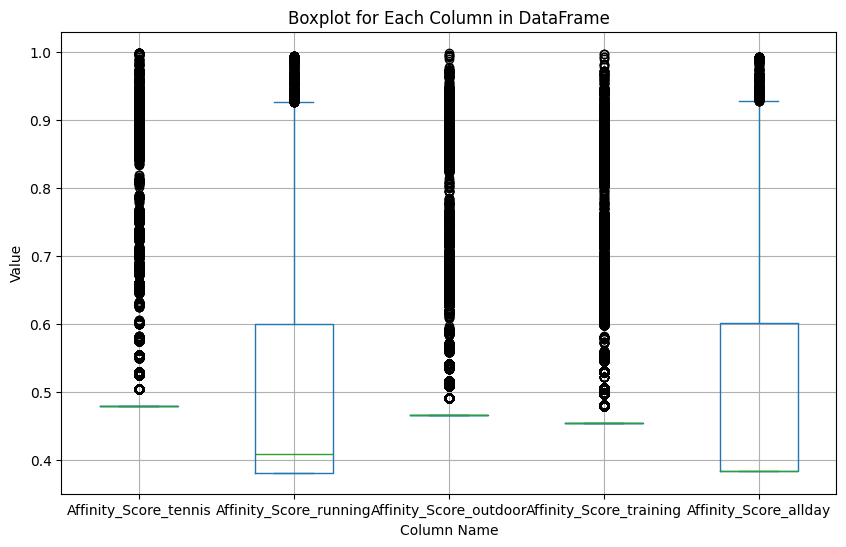

In [71]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6)) # 设置图的大小
df_scored[scored_columns].plot.box(
    title='Boxplot for Each Column in DataFrame',
    grid=True,
    vert=True, # 垂直箱线图
    ax=plt.gca() # 使用当前的 Matplotlib Axes
)

plt.xlabel("Column Name")
plt.ylabel("Value")
plt.show()

In [34]:
df_scored[['member_uid']+ [col for col in df_scored.columns if any(keyword in col for keyword in ['tennis'])]].sort_values(by='Affinity_Score_tennis',ascending=False).head(10)

,member_uid,PDP_View_6M_Count_tennis,PDP_View_Days_Since_Last_tennis,ATC_6M_Count_tennis,ATC_Days_Since_Last_tennis,navi_6M_count_tennis,activity_count_tennis,R_tennis,F_4m_tennis,M_4m_tennis,F_1y_tennis,M_1y_tennis,PDP_View_Days_Since_Last_tennis_score,ATC_Days_Since_Last_tennis_score,R_tennis_score,PDP_View_6M_Count_tennis_score,ATC_6M_Count_tennis_score,navi_6M_count_tennis_score,activity_count_tennis_score,F_4m_tennis_score,M_4m_tennis_score,F_1y_tennis_score,M_1y_tennis_score,Affinity_Score_tennis
30225,1fc88076-c081-472b-a513-3f4258419634,0.0,9999.0,898.0,138.0,0.0,0.0,0.0,205.0,65020.0,277.0,99868.0,1.0,0.998481,1.0,0.0,0.930850,0.000000,0.0,0.967767,1.000000,0.994370,1.000000,0.889457
64584,9039690e-5c61-45ee-a2cc-38cce7d6d3ee,0.0,9999.0,235.0,151.0,1.0,0.0,0.0,245.0,35900.0,286.0,51300.0,1.0,0.997165,1.0,0.0,0.747801,0.196562,0.0,1.000000,0.946407,1.000000,0.942132,0.877678
390057,b85a94e3-2b50-4ac2-bbbf-f4dafc06c6f7,0.0,9999.0,1489.0,134.0,0.0,0.0,0.0,100.0,62710.0,131.0,85920.0,1.0,0.998886,1.0,0.0,1.000000,0.000000,0.0,0.838300,0.996736,0.862765,0.986932,0.851268
251156,cb51354c-46ef-43ae-afe8-18d59e8fa95c,0.0,9999.0,619.0,128.0,0.0,0.0,0.0,82.0,40110.0,97.0,46908.0,1.0,0.999494,1.0,0.0,0.879996,0.000000,0.0,0.802648,0.956412,0.810139,0.934358,0.816954
211219,00fbb774-fe0c-4fcf-bc8e-3137b53bd151,0.0,9999.0,644.0,131.0,0.0,0.0,0.0,66.0,27140.0,66.0,27140.0,1.0,0.999190,1.0,0.0,0.885406,0.000000,0.0,0.763749,0.921167,0.742947,0.886826,0.788532
64449,abea2095-6881-4646-86ca-7f5d76a071a6,0.0,9999.0,458.0,123.0,0.0,0.0,0.0,64.0,18820.0,64.0,18820.0,1.0,1.000000,1.0,0.0,0.838845,0.000000,0.0,0.758244,0.888135,0.737592,0.855026,0.773231
320492,58360b22-4c9f-4e2f-812c-dcfabbef15e3,0.0,9999.0,1067.0,124.0,2.0,0.0,0.0,26.0,14010.0,72.0,38330.0,1.0,0.999899,1.0,0.0,0.954426,0.311543,0.0,0.598663,0.861505,0.758101,0.916814,0.768659
261483,e1dadc44-8b8e-4beb-ac59-8cf2664afc70,0.0,9999.0,21.0,238.0,0.0,0.0,0.0,67.0,25320.0,67.0,25320.0,1.0,0.988356,1.0,0.0,0.423052,0.000000,0.0,0.766440,0.914904,0.745564,0.880796,0.763515
977203,AAHtAaPlAAAF_e4AAUjTQ0TT,0.0,9999.0,0.0,9999.0,0.0,0.0,0.0,141.0,60450.0,146.0,67700.0,1.0,0.000000,1.0,0.0,0.000000,0.000000,0.0,0.900187,0.993424,0.881783,0.966229,0.761835
466728,0c65e762-819b-4d80-81b4-2b9c6eeaee83,0.0,9999.0,325.0,138.0,31.0,0.0,0.0,19.0,15500.0,25.0,22900.0,1.0,0.998481,1.0,0.0,0.792017,0.982808,0.0,0.544151,0.870624,0.575688,0.872070,0.760000


In [35]:
df_scored.shape

(443644, 116)

In [36]:
df_scored.head(5)

,member_uid,PDP_View_6M_Count_allday,PDP_View_6M_Count_outdoor,PDP_View_6M_Count_running,PDP_View_6M_Count_tennis,PDP_View_6M_Count_training,PDP_View_Days_Since_Last_allday,PDP_View_Days_Since_Last_outdoor,PDP_View_Days_Since_Last_running,PDP_View_Days_Since_Last_tennis,PDP_View_Days_Since_Last_training,ATC_6M_Count_allday,ATC_6M_Count_outdoor,ATC_6M_Count_running,ATC_6M_Count_tennis,ATC_6M_Count_training,ATC_Days_Since_Last_allday,ATC_Days_Since_Last_outdoor,ATC_Days_Since_Last_running,ATC_Days_Since_Last_tennis,ATC_Days_Since_Last_training,navi_6M_count_running,navi_6M_count_allday,navi_6M_count_outdoor,navi_6M_count_tennis,navi_6M_count_training,activity_count_allday,activity_count_outdoor,activity_count_running,activity_count_tennis,activity_count_training,R_running,R_tennis,R_allday,R_training,R_outdoor,F_4m_running,F_4m_tennis,F_4m_allday,F_4m_training,F_4m_outdoor,M_4m_running,M_4m_tennis,M_4m_allday,M_4m_training,M_4m_outdoor,F_1y_running,F_1y_tennis,F_1y_allday,F_1y_training,F_1y_outdoor,M_1y_running,M_1y_tennis,M_1y_allday,M_1y_training,M_1y_outdoor,PDP_View_Days_Since_Last_allday_score,PDP_View_Days_Since_Last_outdoor_score,PDP_View_Days_Since_Last_running_score,PDP_View_Days_Since_Last_tennis_score,PDP_View_Days_Since_Last_training_score,ATC_Days_Since_Last_allday_score,ATC_Days_Since_Last_outdoor_score,ATC_Days_Since_Last_running_score,ATC_Days_Since_Last_tennis_score,ATC_Days_Since_Last_training_score,R_running_score,R_tennis_score,R_allday_score,R_training_score,R_outdoor_score,PDP_View_6M_Count_allday_score,PDP_View_6M_Count_outdoor_score,PDP_View_6M_Count_running_score,PDP_View_6M_Count_tennis_score,PDP_View_6M_Count_training_score,ATC_6M_Count_allday_score,ATC_6M_Count_outdoor_score,ATC_6M_Count_running_score,ATC_6M_Count_tennis_score,ATC_6M_Count_training_score,navi_6M_count_running_score,navi_6M_count_allday_score,navi_6M_count_outdoor_score,navi_6M_count_tennis_score,navi_6M_count_training_score,activity_count_allday_score,activity_count_outdoor_score,activity_count_running_score,activity_count_tennis_score,activity_count_training_score,F_4m_running_score,F_4m_tennis_score,F_4m_allday_score,F_4m_training_score,F_4m_outdoor_score,M_4m_running_score,M_4m_tennis_score,M_4m_allday_score,M_4m_training_score,M_4m_outdoor_score,F_1y_running_score,F_1y_tennis_score,F_1y_allday_score,F_1y_training_score,F_1y_outdoor_score,M_1y_running_score,M_1y_tennis_score,M_1y_allday_score,M_1y_training_score,M_1y_outdoor_score,Affinity_Score_tennis,Affinity_Score_running,Affinity_Score_outdoor,Affinity_Score_training,Affinity_Score_allday
2,14749aac-e36a-4477-bfa1-fede3b3c3fe4,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,563.0,9999.0,563.0,9999.0,9999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.00000,0.000000,0.0,0.000000,0.0000,0.943694,0.0,0.943694,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.050000,0.144369,0.050000,0.050000,0.144369
3,793d6c2d-2230-4e64-8287-176a78e0a8bd,0.0,0.0,0.0,0.0,0.0,9999.0,9999.0,9999.0,9999.0,9999.0,72.0,104.0,415.0,32.0,28.0,131.0,145.0,123.0,190.0,203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9999.0,0.0,111.0,75.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0,21.0,0.0,5.0,2.0,2.0,1490.0,0.0,220.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.99919,0.997772,1.0,0.993216,0.9919,1.000000,0.0,1.000000,0.988899,0.992499,0.0,0.0,0.0,0.0,0.0,0.467587,0.688413,0.723417,0.478545,0.44646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.530292,0.0,0.261810,0.271729,0.244146,0.639919,0.0,0.419470,0.0,0.0,0.510541,0.0,0.258279,0.26222,0.224305,0.624675,0.0,0.419470,0.0,0.0,0.123588,0.614968,0.304819,0.301376,0.448343
5,142a2891-6887-4066-8844-4afcc2d55

# ======================== EVALUATION =========================

In [78]:
# ========================== sales share ==========================

query = f'''
SELECT
    member_uid,
        sum( case when vertical = 'Performance All Day' or vertical = 'PAD' then 1 else 0 end) as allday_purchase,
     sum( case when vertical = 'Performance Running' or vertical = 'PR' then 1 else 0 end) as running_purchase,
  sum( case when vertical = 'Performance Training ' or vertical = 'PTR' then 1 else 0 end) as training_purchase,
  sum( case when vertical = 'Performance Tennis' or vertical = 'PT' then 1 else 0 end) as tennis_purchase,
  sum( case when vertical = 'Performance Outdoor' or vertical = 'PO' then 1 else 0 end) as outdoor_purchase,
    sum( case when vertical = 'Performance All Day' or vertical = 'PAD' then `BR Revenue` end)/sum(`BR Revenue`) as allday_sales_share,
     sum( case when vertical = 'Performance Running' or vertical = 'PR' then `BR Revenue` end)/sum(`BR Revenue`) as running_sales_share,
  sum( case when vertical = 'Performance Training ' or vertical = 'PTR' then `BR Revenue` end)/sum(`BR Revenue`) as training_sales_share,
  sum( case when vertical = 'Performance Tennis' or vertical = 'PT' then `BR Revenue` end)/sum(`BR Revenue`) as tennis_sales_share,
  sum( case when vertical = 'Performance Outdoor' or vertical = 'PO' then `BR Revenue` end)/sum(`BR Revenue`) as outdoor_sales_share 
  FROM
    `dwd_dtc_store_sales_order_detail` t1
  LEFT JOIN `dim_product_colors_info` t2
  ON t1.`product_id(style)` = t2.`product_id(style)` 
  where (member_uid != '' or member_uid != NULL ) and is_gift = 0  and t1.date >= {R4M_DATE_SQL} and t1.date < {CURRENT_DATE_SQL}
  group by 1
  '''


try:
    validation = pd.read_sql(query, engine)
    print("\n--- 数据库数据加载到 Pandas DataFrame ---")
except Exception as e:
    print(f"读取数据失败: {e}")


validation = validation.fillna(0)
print(validation.head())


--- 数据库数据加载到 Pandas DataFrame ---
                             member_uid  allday_purchase  running_purchase  training_purchase  tennis_purchase  outdoor_purchase  allday_sales_share  running_sales_share  training_sales_share  tennis_sales_share  outdoor_sales_share
0  0001b584-12d3-47b3-b108-99a5068a168a              1.0               1.0                0.0              0.0               0.0            0.483766             0.516234                   0.0                 0.0                  0.0
1  0003cef5-6da3-4e32-9124-cc6003670825              0.0               0.0                0.0              0.0               1.0            0.000000             0.000000                   0.0                 0.0                  1.0
2  0005484b-4a3e-42bd-b9fb-4380f8cdc644              3.0               0.0                0.0              0.0               0.0            1.000000             0.000000                   0.0                 0.0                  0.0
3  0006fb93-680d-496d-aaf8-2300db

In [82]:
df_scored.shape

(446411, 119)

In [90]:

# validation = validation.fillna(0)
val = df_scored[['member_uid','Predicted_Vertical']+ [col for col in df_scored.columns if any(keyword in col for keyword in ['Affinity'])]].merge(validation, on='member_uid', how='left')
val = val.fillna(0)
print(val.shape)
val.head(5)

(446411, 18)


,member_uid,Predicted_Vertical,Affinity_Score_tennis,Affinity_Score_running,Affinity_Score_outdoor,Affinity_Score_training,Affinity_Score_allday,Max_Affinity_Score,allday_purchase,running_purchase,training_purchase,tennis_purchase,outdoor_purchase,allday_sales_share,running_sales_share,training_sales_share,tennis_sales_share,outdoor_sales_share
0,14749aac-e36a-4477-bfa1-fede3b3c3fe4,tennis,0.478951,0.412829,0.466011,0.455114,0.414649,0.478951,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,793d6c2d-2230-4e64-8287-176a78e0a8bd,running,0.529011,0.876651,0.723882,0.711322,0.820512,0.876651,2.0,10.0,0.0,0.0,0.0,0.137631,0.862369,0.0,0.0,0.0
2,142a2891-6887-4066-8844-4afcc2d551df,allday,0.478951,0.381702,0.466011,0.455114,0.757858,0.757858,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0
3,ce47f1ba-04b9-4733-a43e-ede1fb9a007d,tennis,0.478951,0.410201,0.466011,0.455114,0.383403,0.478951,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,55dca87a-48fb-4844-a891-a9d1b38c265e,outdoor,0.478951,0.381702,0.509894,0.455114,0.383403,0.509894,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [86]:
print(val[val['Predicted_Vertical']=='tennis'].tennis_purchase.mean())
print(val[val['Predicted_Vertical']!='tennis'].tennis_purchase.mean())

0.16060658578856152
0.009884867874481514


In [91]:
def compare_vertical_performance(df, vertical_name):
    """
    比较被预测为特定品类的会员与非该品类会员在实际行为上的差异。
    
    Args:
        df (pd.DataFrame): 包含所有预测和实际行为数据的 DataFrame。
        vertical_name (str): 要比较的品类名称 (例如 'running', 'tennis')。
        
    Returns:
        dict: 包含比较结果的字典。
    """
    
    # 定义当前品类的实际行为列
    purchase_col = f'{vertical_name}_purchase'
    sales_share_col = f'{vertical_name}_sales_share'
    
    # 确保列存在
    if purchase_col not in df.columns or sales_share_col not in df.columns:
        print(f"错误：DataFrame 缺少 {purchase_col} 或 {sales_share_col} 列，跳过 {vertical_name}。")
        return None

    # 1. 划分人群：预测为该品类的会员 vs. 非该品类的会员
    group_predicted = df[df['Predicted_Vertical'] == vertical_name]
    group_not_predicted = df[df['Predicted_Vertical'] != vertical_name] # 包含 'No_Interest' 和其他品类

    # 如果需要更精确的“非该品类”，可以排除 'No_Interest'
    # group_not_predicted = df[(df['Predicted_Vertical'] != vertical_name) & (df['Predicted_Vertical'] != 'No_Interest')]

    # 2. 计算各项指标

    # CVR (此处用 Purchase Rate 代替：实际购买人数 / 组内总人数)
    cvr_predicted = (group_predicted[purchase_col] > 0).sum() / len(group_predicted) if len(group_predicted) > 0 else 0
    cvr_not_predicted = (group_not_predicted[purchase_col] > 0).sum() / len(group_not_predicted) if len(group_not_predicted) > 0 else 0

    # 平均 Purchase (购买次数/件数)
    avg_purchase_predicted = group_predicted[purchase_col].mean() if len(group_predicted) > 0 else 0
    avg_purchase_not_predicted = group_not_predicted[purchase_col].mean() if len(group_not_predicted) > 0 else 0

    # 平均 Sales Share
    avg_sales_share_predicted = group_predicted[sales_share_col].mean() if len(group_predicted) > 0 else 0
    avg_sales_share_not_predicted = group_not_predicted[sales_share_col].mean() if len(group_not_predicted) > 0 else 0

    # 3. 组织结果
    results = {
        'Vertical': vertical_name,
        'Predicted_Group_Size': len(group_predicted),
        'Not_Predicted_Group_Size': len(group_not_predicted),
        'CVR_Predicted': cvr_predicted,
        'CVR_Not_Predicted': cvr_not_predicted,
        'CVR_Ratio': cvr_predicted / cvr_not_predicted if cvr_not_predicted > 0 else np.nan,
        'Avg_Purchase_Predicted': avg_purchase_predicted,
        'Avg_Purchase_Not_Predicted': avg_purchase_not_predicted,
        'Purchase_Ratio': avg_purchase_predicted / avg_purchase_not_predicted if avg_purchase_not_predicted > 0 else np.nan,
        'Avg_Sales_Share_Predicted': avg_sales_share_predicted,
        'Avg_Sales_Share_Not_Predicted': avg_sales_share_not_predicted,
        'Sales_Share_Ratio': avg_sales_share_predicted / avg_sales_share_not_predicted if avg_sales_share_not_predicted > 0 else np.nan,
    }
    return results

# --- 3. 循环比较所有品类 ---

all_verticals = ['tennis', 'running', 'outdoor', 'training', 'allday']
comparison_results = []

for vertical in all_verticals:
    result = compare_vertical_performance(val, vertical)
    if result:
        comparison_results.append(result)

df_comparison = pd.DataFrame(comparison_results)

print("\n--- ✅ Affinity Score 预测效果验证结果 ---")
# 打印所有结果
print(df_comparison.round(4))

# 可以进一步分析，例如找出 CVR Ratio 最高的品类
print("\n--- 按 CVR Ratio 排序的品类 ---")
print(df_comparison.sort_values(by='CVR_Ratio', ascending=False).round(4))


--- ✅ Affinity Score 预测效果验证结果 ---
   Vertical  Predicted_Group_Size  Not_Predicted_Group_Size  CVR_Predicted  CVR_Not_Predicted  CVR_Ratio  Avg_Purchase_Predicted  Avg_Purchase_Not_Predicted  Purchase_Ratio  Avg_Sales_Share_Predicted  Avg_Sales_Share_Not_Predicted  Sales_Share_Ratio
0    tennis                115400                    331011         0.0864             0.0044    19.7263                  0.1606                      0.0099         16.2477                     0.0696                         0.0017            41.0264
1   running                114097                    332314         0.3327             0.0438     7.5994                  0.6355                      0.0883          7.1955                     0.3060                         0.0207            14.7958
2   outdoor                 51695                    394716         0.2545             0.0069    37.1552                  0.4044                      0.0125         32.4066                     0.1995                

In [92]:
correlation_matrix = val.corr()
print("\n--- 完整相关系数矩阵 ---")
correlation_matrix

ValueError: could not convert string to float: '14749aac-e36a-4477-bfa1-fede3b3c3fe4'

# ========================= WRITE TO MYSQL ==========================

In [66]:
# try:
#     # 4. 使用 to_sql() 写入数据
#     TABLE_NAME = 'ds_temp_vertical_affinity_1127' # 你想在 MySQL 中创建的表名

#     df_scored.to_sql(
#         name=TABLE_NAME,      # 表名
#         con=engine,           # 数据库连接引擎
#         if_exists='replace',  # 如果表已存在：'fail', 'replace' (替换), 或 'append' (追加)
#         index=False,          # 不将 DataFrame 的 index 写入数据库作为一列
#         chunksize=1000        # 可选：分块写入，对大型数据集很有用
#     )
    
#     print(f"\nDataFrame 已成功写入 MySQL 数据库表: {TABLE_NAME}")

# except Exception as e:
#     print(f"\n写入数据库失败，请检查连接信息和依赖库是否正确。错误信息: {e}")


DataFrame 已成功写入 MySQL 数据库表: ds_temp_vertical_affinity_1127
